In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git pull

Already up to date.


In [3]:
import os
from collections import Counter
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from PIL import Image
from scipy.stats import binom
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret import show

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Data/repos/zoobot/zoobot/estimators/make_predictions.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/mini

In [4]:
QUESTION = 'smooth'
save_dir = '/data/repos/zoobot/analysis'

if QUESTION == 'bars':
    label_col = 't03_bar_a06_bar_count'
    frac_col = 't03_bar_a06_bar_fraction'
elif QUESTION == 'smooth':
    label_col = 't01_smooth_or_features_a01_smooth_count'
    frac_col = 't01_smooth_or_features_a01_smooth_fraction'
else:
    raise ValueError
total_col = 'total_votes'
    

In [5]:
df = pd.read_parquet('/data/repos/zoobot/notebooks/{}_test_predictions_and_gz2_catalog.parquet'.format(QUESTION))  # so this does exist, just need to find it - time machine?

In [6]:
df['rho_predictions_arr'] = df['rho_predictions'].apply(lambda x: json.loads(x))

In [7]:
df['rho_predictions_arr'].head()

2499    [0.004373430740088224, 0.00024163565831258893,...
2488    [0.004601737018674612, 0.0001537502248538658, ...
2484    [0.0007981372182257473, 0.00230843061581254, 0...
2435    [0.0008740660850889981, 0.0036228245589882135,...
2160    [0.001903498312458396, 0.0020893479231745005, ...
Name: rho_predictions_arr, dtype: object

In [8]:
def bcnn_probs_by_k(row):
    individual_probs_by_k = [make_predictions.binomial_prob_per_k(rho, row[total_col]) for rho in row['rho_predictions_arr']]
    return np.mean(individual_probs_by_k, axis=0)

In [9]:
def cnn_probs_by_k(row):
    possible_k = list(range(row[total_col] + 1))
    return np.array([binom.pmf(k=k, n=row[total_col], p=row['rho_predictions_arr'][0]) for k in possible_k])

In [10]:
def likelihood_of_prediction(row, prediction_col):
    actual_k = row[label_col]
#     print(actual_k)
#     print(len(row[prediction_col]))
    return row[prediction_col][actual_k]

In [11]:
def add_loss_metrics(df):
    df['cnn_probs_by_k'] = df.apply(cnn_probs_by_k, axis=1)
    df['bcnn_probs_by_k'] = df.apply(bcnn_probs_by_k, axis=1)
    df['bcnn_likelihood'] = df.apply(likelihood_of_prediction, axis=1, prediction_col='bcnn_probs_by_k')
    df['cnn_likelihood'] = df.apply(likelihood_of_prediction, axis=1, prediction_col='cnn_probs_by_k')
    df['absolute_error'] = np.abs(df['rho_prediction'] - df[frac_col])
    return df

In [12]:
df = add_loss_metrics(df)

In [13]:
galaxy = df.iloc[100]
len(galaxy['cnn_probs_by_k']), galaxy[label_col], galaxy[total_col]

(39, 8, 38)

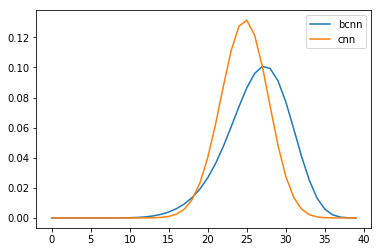

In [14]:
galaxy = df.sample().squeeze()
# galaxy['bcnn_likelihood'], galaxy['cnn_likelihood']
# galaxy[frac_col], galaxy['rho_predictions_arr'][0], np.mean(galaxy['rho_predictions_arr'])
plt.plot(galaxy['bcnn_probs_by_k'], label='bcnn')
plt.plot(galaxy['cnn_probs_by_k'], label='cnn')
plt.legend()

In [15]:
np.sum(galaxy['bcnn_probs_by_k']), np.sum(galaxy['cnn_probs_by_k'])  # should be approx. 1

(0.9999999999999867, 0.9999999999999843)

In [16]:
# df['absolute_error_in_fraction'] = np.abs(df['rho_prediction'] - df['t03_bar_a06_bar_fraction'])
# df['absolute_error_in_fraction'].mean()
np.sum(df['absolute_error'] < .2) / len(df)

0.934

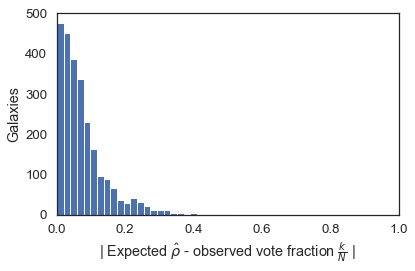

In [17]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots()
ax.hist(df['absolute_error'], bins=25)
# ax.axvline(sim_model.mean_abs_rho_error, color='r') 
ax.set_xlim([0, 1.])
ax.set_ylabel('Galaxies')
ax.set_xlabel(r'| Expected $\hat{\rho}$ - observed vote fraction $\frac{k}{N}$ |')
fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'difference_in_rho.png'))
# fig.savefig(os.path.join(save_dir, 'difference_in_rho.pdf'))

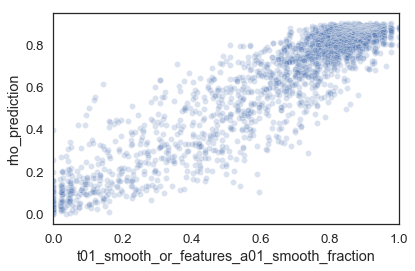

In [18]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots()
sns.scatterplot(data=df, y='rho_prediction', x=frac_col, alpha=0.2)
# ax.axvline(sim_model.mean_abs_rho_error, color='r') 
ax.set_xlim([0, 1.])
# ax.set_ylabel('Galaxies')
# ax.set_xlabel(r'| Expected $\hat{\rho}$ - observed vote fraction $\frac{k}{N}$ |')
fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'difference_in_rho.png'))
# fig.savefig(os.path.join(save_dir, 'difference_in_rho.pdf'))

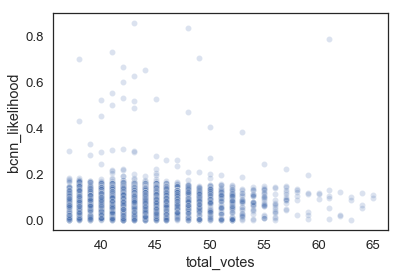

In [19]:
sns.scatterplot(data=df, y='bcnn_likelihood', x='total_votes', alpha=0.2)

In [20]:
def perfect_model_performance(df, n_galaxies=250):
    binary_errors = 0
    likelihoods = np.zeros(n_galaxies)
    deviation = np.zeros_like(likelihoods)
    for n in range(n_galaxies):
        # pick random galaxy
        gal_n = np.random.choice(range(len(df)))
        # get k/N as observed, i.e. rho_proxy
        rho_proxy = df[frac_col][gal_n]
#         k_obs = df[label_col][gal_n] # same distribution as rho that we see, unbiased
        total_votes = df[total_col][gal_n]
        k_a = binom.rvs(n=total_votes, p=rho_proxy)
        k_b = binom.rvs(n=total_votes, p=rho_proxy)
        # how many did our simple redraw get 'wrong' for binary classification?
        deviation[n] = np.abs(k_a - k_b)
        if (k_a > total_votes/2. and k_b < total_votes/2.) or (k_a < total_votes/2. and k_b > total_votes/2.):
            binary_errors += 1
        # how surprised should we be?
        likelihoods[n] = binom.pmf(n=total_votes, k=k_a, p=rho_proxy)
    return likelihoods, deviation, binary_errors / n_galaxies

In [21]:
likelihoods, deviations, binary_acc = perfect_model_performance(
#     df.query('{} > 0.01'.format(frac_col)).query('{} < 0.99'.format(frac_col)).reset_index(),
    df,
    n_galaxies=50000)

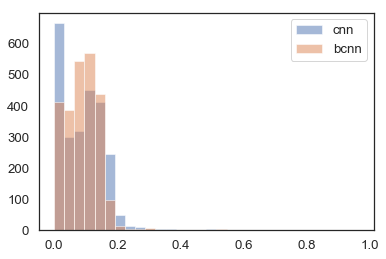

In [22]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(df['cnn_likelihood'], alpha=0.5, label='cnn', density=None, bins=30)
ax.hist(df['bcnn_likelihood'], alpha=0.5,label='bcnn', density=None, bins=bins)
# ax.hist(likelihoods, density=True, alpha=0.5, label='perfect', bins=bins)
# ax.set_xlim([0., 0.5])
ax.legend()

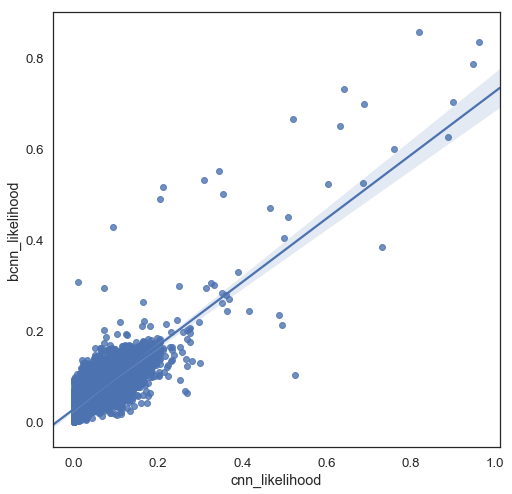

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x='cnn_likelihood', y='bcnn_likelihood', ax=ax)
# ax.plot([0., 1.], [0., 1.], 'k--')
# ax.set_xlim([0., 0.5])
# ax.set_ylim([0., 0.5])

In [24]:

max_errors = list(range(0, 10))
perfect_accepted = [np.mean(deviations < max_error) for max_error in max_errors]

model_deviations = np.abs(df[label_col] - df['rho_prediction'] * df[total_col])
model_accepted = [np.mean(model_deviations < max_error) for max_error in max_errors]

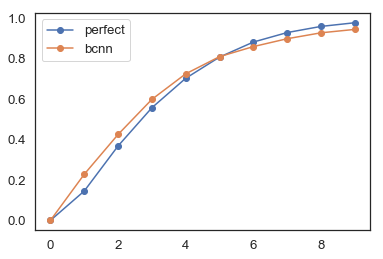

In [25]:

fig, ax = plt.subplots()
ax.plot(max_errors, perfect_accepted, label='perfect', marker='o')
ax.plot(max_errors, model_accepted, label='bcnn', marker='o')
# ax.hist(np.abs(df[label_col] - df['rho_prediction'] * df['total_votes']), bins=30, density=True, alpha=0.5, label='bcnn')
ax.legend()

In [26]:


def evaluate_discrete_coverage(volunteer_fracs, total_votes, k_predictions):
    """Calculate discrete coverage, by max allowed error, given actual votes and mean k predictions
    
    Args:
        volunteer_votes (list): of shape (subject_n), values of k for that subject
        k_predictions (list): of shape (subject_n, sample_n, k), values of p(k), num of k (i.e. last dim) varies by subject
        max_possible_k (int): Default 20. Don't test errors higher than this.
    
    Raises:
        ValueError: [description]
    
    Returns:
        [type]: [description]
    """
    data = []
#     if volunteer_votes.mean() < 1.:  # make sure this isn't the vote fractions!
#         raise ValueError('Expected integer vote counts (k), not fractions, but mean "vote" is below 1.')
    n_subjects = len(volunteer_fracs)
    
    # mean_posterior = acquisition_utils.get_mean_predictions(sample_probs_by_k)
    accepted_frac_errors = np.array(np.linspace(0., 0.5, 51))
#     print(accepted_frac_errors)
    for frac_error_width in accepted_frac_errors:
#         print(frac_error_width)
        for subject_n in range(n_subjects):
#         for subject_n in range(2):
            
#             print('subject', subject_n)
            p_of_k = k_predictions[subject_n]  # of dim [sample_n, k] and value p(k given sample)
#             print('p of k predictions', p_of_k)
            possible_fracs = np.arange(len(p_of_k)) / total_votes[subject_n]  # 0 to k_n
            p_of_frac = p_of_k           
#             print('possible_fracs', possible_fracs)
 
            expected_frac = np.sum(p_of_frac * possible_fracs)  # expected frac per subject
#             print('expected_frac', expected_frac)
        
            actual_frac = volunteer_fracs[subject_n]
#             print('actual frac', actual_frac)
            
#             print('frac error width', frac_error_width)
            # use min/max because slice (below) will fail if min_k or max_k are negative
            max_frac = np.min([expected_frac + frac_error_width, 1.])
            min_frac = np.max([expected_frac - frac_error_width, 0])
#             print(min_frac, max_frac)
            assert min_frac <= max_frac
    
            # warning, slice will fail if min_k or max_k are negative
            frac_indices_within_errors = (possible_fracs >= min_frac) & (possible_fracs <= max_frac)
#             print('indices within errors', dict(zip(np.around(p_of_frac, decimals=3), frac_indices_within_errors)))
#             print('selected: ', p_of_frac[frac_indices_within_errors])
            p_frac_in_error_bar = np.sum(p_of_frac[frac_indices_within_errors])
#             print('p frac in error bar', p_frac_in_error_bar)
            frac_in_error_bar = float(min_frac <= actual_frac <= max_frac)
#             print('frac in error bar', frac_in_error_bar)
#             print('\n\n')
            data.append({
                'max_frac_error': frac_error_width,
                'actual_allowed_error': max_frac - min_frac,
                'prediction': p_frac_in_error_bar,
                'observed': frac_in_error_bar,
                'max_frac': max_frac,
                'min_frac': min_frac,
                'most_likely_frac': expected_frac,
                'actual_frac': actual_frac,
                'subject_n': subject_n
                })
    df = pd.DataFrame(data=data)
    return df

In [27]:
# tmp_df = df.sample(3)

In [28]:
# bcnn_coverage_df = evaluate_discrete_coverage(tmp_df[frac_col].values, tmp_df['bar_total-votes'].values, tmp_df['bcnn_probs_by_k'].values, max_possible_frac=.5)
# bcnn_grp_df = bcnn_coverage_df.groupby('max_frac_error').agg({'prediction': np.mean, 'observed': np.mean}).reset_index()
# bcnn_grp_df['max_frac_error'] = bcnn_grp_df['max_frac_error'].astype(float)

In [29]:
bcnn_coverage_df = evaluate_discrete_coverage(df[frac_col].values, df[total_col].values, df['bcnn_probs_by_k'].values)
bcnn_grp_df = bcnn_coverage_df.groupby('max_frac_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()
bcnn_grp_df['max_frac_error'] = bcnn_grp_df['max_frac_error'].astype(float)
bcnn_grp_df['error'] = bcnn_grp_df['prediction'] - bcnn_grp_df['observed']
bcnn_grp_df['relative_error'] = bcnn_grp_df['error'] / bcnn_grp_df['observed']
save_loc = os.path.join(save_dir, QUESTION + '_bcnn_fractional_coverage_df.csv')
bcnn_grp_df.to_csv(save_loc, index=False)
bcnn_grp_df

,max_frac_error,prediction,observed,error,relative_error
0,0.00,0.000000,0.0,0.000000,NaN
1,0.01,286.601748,243.0,43.601748,1.794311e-01
2,0.02,566.353609,486.0,80.353609,1.653366e-01
3,0.03,832.306102,723.0,109.306102,1.511841e-01
4,0.04,1083.759016,944.0,139.759016,1.480498e-01
5,0.05,1309.714599,1155.0,154.714599,1.339520e-01
6,0.06,1509.425344,1342.0,167.425344,1.247581e-01
7,0.07,1689.423922,1516.0,173.423922,1.143957e-01
8,0.08,1840.133727,1669.0,171.133727,1.025367e-01
9,0.09,1969.895163,1790.0,179.895163,1.005001e-01


In [30]:
save_loc

'/data/repos/zoobot/analysis/smooth_bcnn_fractional_coverage_df.csv'

In [31]:
cnn_coverage_df = evaluate_discrete_coverage(df[frac_col].values, df[total_col].values, df['cnn_probs_by_k'].values)
cnn_grp_df = cnn_coverage_df.groupby('max_frac_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()
cnn_grp_df['max_frac_error'] = cnn_grp_df['max_frac_error'].astype(float)
cnn_grp_df['error'] = cnn_grp_df['prediction'] - cnn_grp_df['observed']
cnn_grp_df['relative_error'] = cnn_grp_df['error'] / cnn_grp_df['observed']
cnn_grp_df.to_csv(os.path.join(save_dir, QUESTION + '_cnn_fractional_coverage_df.csv'), index=False)
cnn_grp_df

,max_frac_error,prediction,observed,error,relative_error
0,0.00,0.000000,0.0,0.000000,NaN
1,0.01,364.829550,252.0,112.829550,0.447736
2,0.02,707.753927,473.0,234.753927,0.496309
3,0.03,1025.896180,707.0,318.896180,0.451055
4,0.04,1302.970166,934.0,368.970166,0.395043
5,0.05,1551.692816,1120.0,431.692816,0.385440
6,0.06,1761.895329,1296.0,465.895329,0.359487
7,0.07,1933.844382,1447.0,486.844382,0.336451
8,0.08,2074.131165,1573.0,501.131165,0.318583
9,0.09,2182.793378,1690.0,492.793378,0.291594


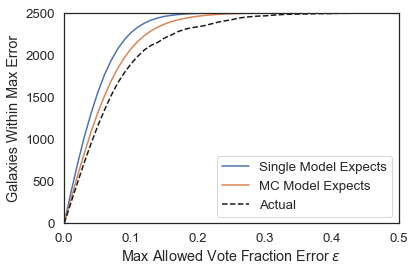

In [41]:
sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots()
ax.plot(cnn_grp_df['max_frac_error'], cnn_grp_df['prediction'], label='Single Model Expects')
ax.plot(bcnn_grp_df['max_frac_error'], bcnn_grp_df['prediction'], label='MC Model Expects')
ax.plot(bcnn_grp_df['max_frac_error'], bcnn_grp_df['observed'], 'k--', label='Actual')
ax.set_xlabel(r'Max Allowed Vote Fraction Error $\epsilon$')
ax.set_ylabel('Galaxies Within Max Error')
ax.set_ylim([0., len(df)])
ax.set_xlim([0., .5])
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(save_dir, '{}_fractional_coverage.pdf'.format(QUESTION)))
fig.savefig(os.path.join(save_dir, '{}_fractional_coverage.png'.format(QUESTION)))

In [33]:
# overplot

In [34]:
bar_bcnn = pd.read_csv(os.path.join(save_dir, 'bars' + '_bcnn_fractional_coverage_df.csv'))
bar_cnn = pd.read_csv(os.path.join(save_dir, 'bars' + '_cnn_fractional_coverage_df.csv'))
smooth_bcnn = pd.read_csv(os.path.join(save_dir, 'smooth' + '_bcnn_fractional_coverage_df.csv'))
smooth_cnn = pd.read_csv(os.path.join(save_dir, 'smooth' + '_cnn_fractional_coverage_df.csv'))

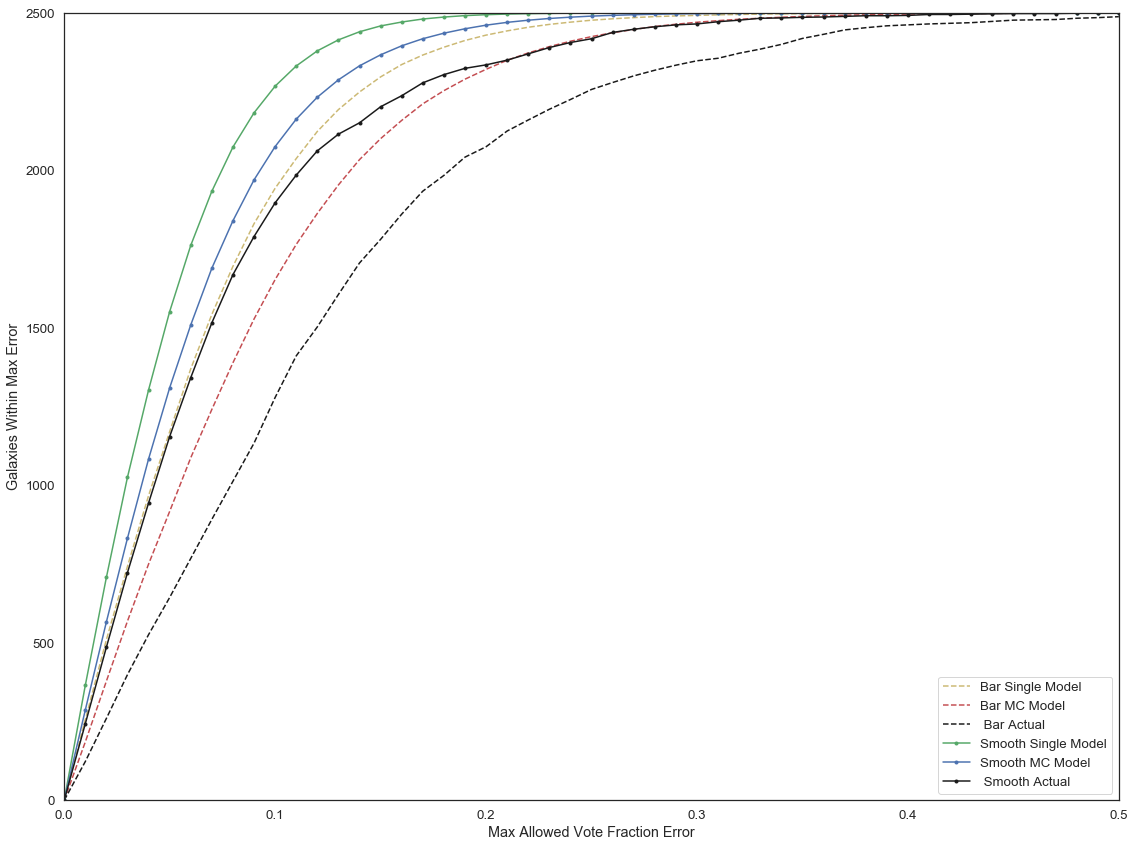

In [40]:
sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(bar_cnn['max_frac_error'], bar_cnn['prediction'], 'y--', label='Bar Single Model')
ax.plot(bar_bcnn['max_frac_error'], bar_bcnn['prediction'], 'r--', label='Bar MC Model')
ax.plot(bar_bcnn['max_frac_error'], bar_bcnn['observed'], 'k--', label=' Bar Actual')
ax.plot(smooth_cnn['max_frac_error'], smooth_cnn['prediction'], 'g.-', label='Smooth Single Model')
ax.plot(smooth_bcnn['max_frac_error'], smooth_bcnn['prediction'], 'b.-', label='Smooth MC Model')
ax.plot(smooth_bcnn['max_frac_error'], smooth_bcnn['observed'], 'k.-', label=' Smooth Actual')
ax.set_xlabel('Max Allowed Vote Fraction Error')
ax.set_ylabel('Galaxies Within Max Error')
ax.set_ylim([0., len(df)])
ax.set_xlim([0., .5])
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'overlaid_fractional_coverage.pdf'))
fig.savefig(os.path.join(save_dir, 'overlaid_fractional_coverage.png'))

In [36]:
bar_bcnn

,max_frac_error,prediction,observed,error,relative_error
0,0.00,0.000000,0.0,0.000000,NaN
1,0.01,185.272628,123.0,62.272628,0.506282
2,0.02,378.278797,260.0,118.278797,0.454918
3,0.03,568.930694,399.0,169.930694,0.425891
4,0.04,749.993648,526.0,223.993648,0.425843
5,0.05,917.300629,644.0,273.300629,0.424380
6,0.06,1087.632745,768.0,319.632745,0.416188
7,0.07,1241.085232,892.0,349.085232,0.391351
8,0.08,1389.281230,1013.0,376.281230,0.371452
9,0.09,1528.135057,1134.0,394.135057,0.347562


In [37]:
bar_cnn

,max_frac_error,prediction,observed,error,relative_error
0,0.00,0.000000,0.0,0.000000,NaN
1,0.01,255.894691,133.0,122.894691,0.924020
2,0.02,509.809949,265.0,244.809949,0.923811
3,0.03,742.970425,387.0,355.970425,0.919820
4,0.04,967.445709,502.0,465.445709,0.927183
5,0.05,1170.408789,631.0,539.408789,0.854848
6,0.06,1370.059028,767.0,603.059028,0.786257
7,0.07,1542.805322,901.0,641.805322,0.712326
8,0.08,1695.376157,1019.0,676.376157,0.663765
9,0.09,1830.655370,1135.0,695.655370,0.612912


## Check Mean is Unchanged and variance of probabilities is decreased (counterintuitive)

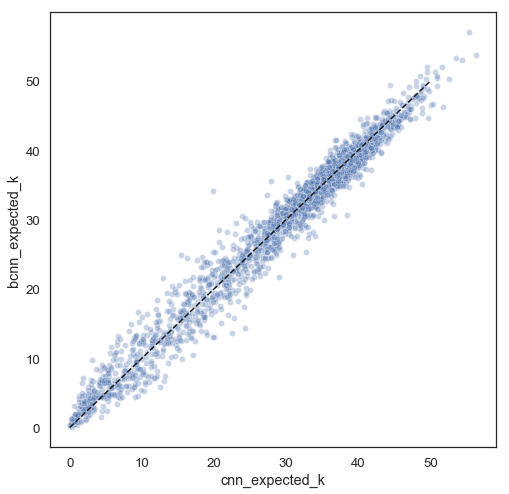

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
df['bcnn_expected_k'] = df['bcnn_probs_by_k'].apply(lambda x: np.sum(x * np.arange(len(x))))
df['cnn_expected_k'] = df['cnn_probs_by_k'].apply(lambda x: np.sum(x * np.arange(len(x))))
sns.scatterplot(data=df, x='cnn_expected_k', y='bcnn_expected_k', ax=ax, alpha=0.3)
ax.plot([0., 50.], [0., 50.], 'k--')

(0.0, 10.0)

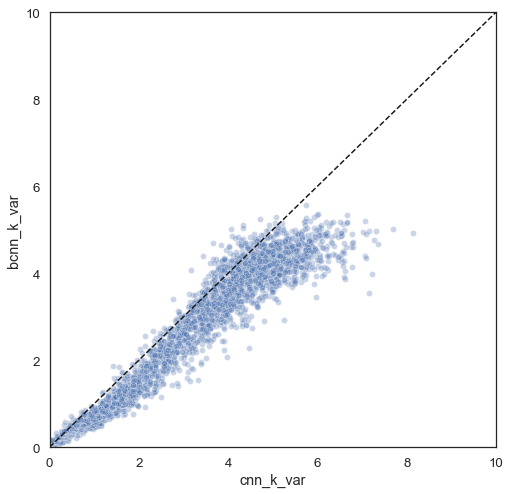

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
df['bcnn_k_var'] = df['bcnn_probs_by_k'].apply(lambda x: np.sum(x ** 2 * np.arange(len(x))))
df['cnn_k_var'] = df['cnn_probs_by_k'].apply(lambda x: np.sum(x ** 2 * np.arange(len(x))))
sns.scatterplot(data=df, x='cnn_k_var', y='bcnn_k_var', ax=ax, alpha=0.3)
ax.plot([0., 10.], [0., 10.], 'k--')
ax.set_xlim([0., 10.])
ax.set_ylim([0., 10.])